# Amortized Inference for a NLME Model

In [1]:
# load necessary packages
import numpy as np
import pandas as pd
import itertools

# for plots
import matplotlib.pyplot as plt
from IPython.display import display
from heatmap import corrplot

# optimization
from pypesto import visualize, optimize, profile, engine

from inference.inference_functions import run_population_optimization, create_boundaries_from_prior
from inference.nlme_objective import ObjectiveFunctionNLME
from inference.helper_functions import transform_pesto_results
from inference.ploting_routines import plot_real_vs_synthetic, plot_real_and_estimated, \
    plot_parameter_estimates, plot_estimated_distributions, visualize_pesto_result

/Users/jonas.arruda/miniconda/envs/AmortizedNLMEs/lib/python3.9/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-small', 'fröhlich-large', 'fröhlich-sde', 'pharmacokinetic_model', 
              'clairon_model', 'clairon_small_model'][1]

## Load model

In [3]:
if model_name == 'fröhlich-small':
    from models.froehlich_model_small import FroehlichModelSmall
    model = FroehlichModelSmall(load_best=True)
    
    use_presimulation = False
elif model_name == 'fröhlich-large':
    from models.froehlich_model_large import FroehlichModelLarge
    model = FroehlichModelLarge(load_best=True)
    
    use_presimulation = True
    presimulation_path = 'data/presimulations_froehlich_large'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    model = FroehlichModelSDE(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_froehlich_sde'
    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    model = PharmacokineticModel(load_best=True)
    
    use_presimulation = True
    presimulation_path = 'data/presimulations_pharma'
elif model_name == 'clairon_model':
    from models.clairon_model import ClaironModel
    model = ClaironModel(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_clairon'
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    model = ClaironSmallModel(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_small_clairon'
else:
    raise NotImplementedError('model not implemented')

path_store_network = 'networks/' + model.network_name

# assemble simulator and prior
simulator = model.build_simulator()
trainer = model.build_trainer(path_store_network)

  Activating project at `~/PyCharm Projects/AmortizedNLME/SimulatorFroehlich`


using LSTM with 256 units as summary network
using a 9-layer cINN as inference network
prior mean: [ 0 -1  0 12  0  1 -3 -6  0  2 -1]
prior covariance diagonal: [5. 5. 2. 1. 2. 2. 2. 5. 2. 6. 2.]
Using the large Froehlich model


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 11)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 180, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from networks/amortizer-large-fro-9layers-LSTM-1000epochs/history_1000.pkl.
INFO:root:Loaded simulation memory from networks/amortizer-large-fro-9layers-LSTM-1000epochs/memory.pkl
INFO:root:Networks loaded from networks/amortizer-large-fro-9layers-LSTM-1000epochs/ckpt-1000
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 1829970   
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  264192    
                                                                 
Total params: 2,094,162
Trainable params: 2,093,964
Non-trainable params: 198
_________________________________________________________________
None


,$\delta_1 m_0$,$\delta_2$,$e_0 m_0$,$k_2 m_0 scale$,$k_2$,$k_1 m_0$,$r_0 m_0$,$\gamma$,$t_0$,$offset$,$\sigma$
0,1.2,0.6,0.85,1000000.0,1.9,5.5,0.1,0.01,0.9,8.0,0.031623


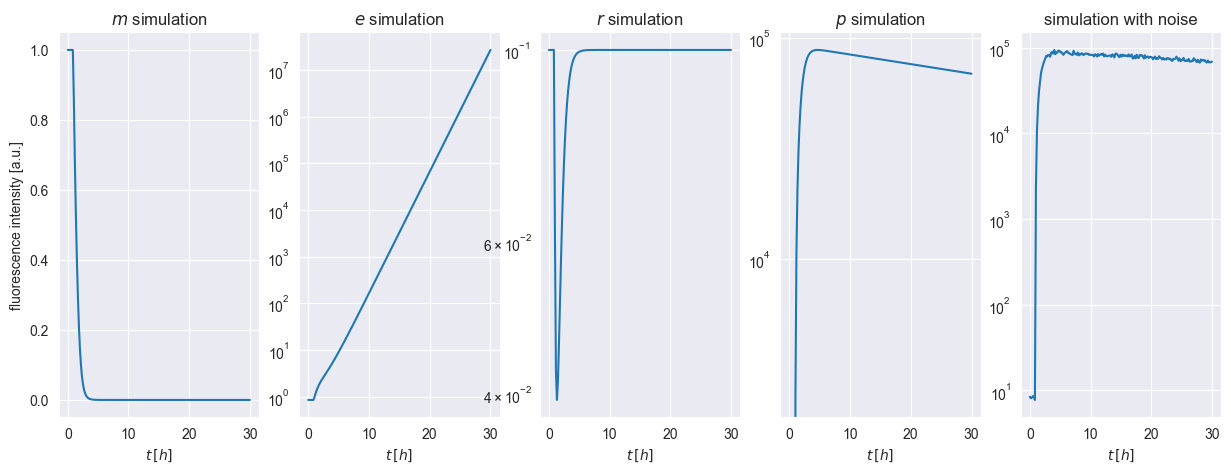

In [4]:
model.print_and_plot_example()

## Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.
One part of the objective function increases logarithmically with the sample size $M$.
On the other hand, the approximation gets better (therby decreasing the value?!)

$\beta$ is called ```theta_population``` in the code.


$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

# Define Objective Function

In [5]:
use_covariates = False

if 'fröhlich' in model_name:
    prior_std = model.prior_std
    prior_mean = model.prior_mean
    param_names = model.param_names
elif 'clairon' in model_name:
    prior_std = model.prior_std
    prior_mean = model.prior_mean
    param_names = model.param_names 
    if use_covariates:
        param_names += ['c_age', 'c_gender']
    
    from models.clairon_model import batch_simulator, convert_to_observables
elif 'pharmacokinetic_model' == model_name:
    prior_std = model.prior_std[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,16]]
    prior_mean = model.prior_mean[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,16]]
    param_names = model.param_names[:14] + model.param_names[16:]
else:
    raise NotImplementedError('model not implemented')

In [6]:
# for huber loss
# 1.5 times the median of the posterior standard deviations
#samples_sigma = np.median(model.draw_posterior_samples(data=obs_data, n_samples=1000)[:, :, -1])
#huber_loss = np.exp(samples_sigma)*1.5
huber_loss = None
print(huber_loss)

None


In [39]:
cov_type = ['diag', 'cholesky'][0]

if use_covariates and 'clairon' in model_name:
    #simulator_noise_free = model.build_simulator(with_noise=False)
    data, covariates = model.load_data(n_data=50, load_covariates=True)
    def covariate_mapping(param_samples, covariates, params, tres=0.001):
        additive_cov = np.sum(params[-2:]*covariates, axis=1)
        #multiplicative_cov = np.sum(np.exp(params[-2:])*covariates, axis=1)
        transformed_param_samples = np.exp(param_samples)
        for s_id in range(transformed_param_samples.shape[0]):
            transformed_param_samples[s_id, :, 0] -= additive_cov[s_id]  # cov on one parameter
            #transformed_param_samples[s_id, :, 0] /= multiplicative_cov[s_id]


            #_, t_measurements, dose_amount, doses_time_points = convert_to_observables(data[s_id])
            #median_param = np.median(param_samples[s_id], axis=0)
            #sim = batch_simulator(median_param[np.newaxis],
            #                            t_measurements=t_measurements,
            #                            dose_amount=dose_amount,
            #                            t_doses=doses_time_points)
            #y, _, _, _ = convert_to_observables(sim[0])
            #transformed_param_samples[s_id, :, -4] -= np.exp(params[-4]) + np.exp(params[-3])*np.median(y)

        transformed_param_samples[transformed_param_samples < 0] = tres

        # append parameters of covariances, which are (log) normal with mean beta
        param_samples_cov = np.concatenate((np.log(transformed_param_samples),
                                            np.ones((transformed_param_samples.shape[0],transformed_param_samples.shape[1], 2))*params[-2:]),
                                           axis=2)
        return param_samples_cov
    param_dim = len(param_names)
else:
    covariate_mapping = None
    covariates = None
    param_dim = None

obj_fun_amortized = ObjectiveFunctionNLME(model_name=model.name,
                                              param_samples=np.empty((1,1,1)),
                                              prior_mean=prior_mean,
                                              prior_std=prior_std,
                                              covariance_format=cov_type,
                                              covariates=covariates,
                                              covariate_mapping=covariate_mapping,
                                              param_dim=param_dim,
                                              # np.exp(-3.41) * 1.5
                                              penalize_correlations=None,
                                              huber_loss_delta=huber_loss)

In [40]:
pop_param_names = ['pop-' + name for name in param_names]
var_param_names = ['var-' + name for name in param_names]
full_param_names = pop_param_names + var_param_names

if cov_type == 'cholesky' and len(full_param_names) == len(param_names)*2:
    # add  correlation names to full parameter names
    # make all possible combinations of parameter names
    combinations = list(itertools.combinations(param_names, 2))
    # create upper triangular matrix of parameter names
    psi_inverse_upper = np.chararray((len(param_names), len(param_names)), itemsize=100, unicode=True)
    psi_inverse_upper[np.diag_indices(len(param_names))] = "1"
    psi_inverse_upper[np.triu_indices(len(param_names), k=1)] = [f"corr_{x}_{y}" for x, y in combinations]
    # extract lower triangular matrix of parameter names, so that they are ordered as in the covariance matrix
    corr_names = list(psi_inverse_upper.T[np.tril_indices(len(param_names), k=-1)])
    # add correlation names to full parameter names
    full_param_names = full_param_names + corr_names
    print(full_param_names)

# Load Data

In [41]:
# define how many data points are used for optimization
n_data = 100 # 50
load_real_data = True
# load data
if 'fröhlich' in model_name:
    obs_data, true_pop_parameters = model.load_data(n_data=n_data, load_eGFP=load_real_data, load_d2eGFP=False)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data, true_pop_parameters_sde = model_sde.load_data(n_data=n_data, load_eGFP=load_real_data, load_d2eGFP=False)
    #true_pop_parameters = None
else:
    obs_data = model.load_data(n_data=n_data)
    true_pop_parameters = None
results_to_compare = None

In [42]:
if not load_real_data:
    if model_name == 'fröhlich-small':
        path = f'output/results_monolix/small_model/estimated_parameters_synthetic_{n_data}_cells.csv'
        results_monolix = pd.read_csv(path, index_col=0, header=0)
        results_to_compare = results_monolix[results_monolix.columns[0]].values[[0, 1, 2, 3, 4, 10, 5, 6, 7, 8, 9]]
        results_to_compare[5] = np.log(results_to_compare[5])  # sigma to log
        results_to_compare = np.concatenate((results_to_compare, [0]))[np.newaxis, :]
    elif model_name == 'fröhlich-large':
        path = f'output/results_monolix/large_model/synthetic_{n_data}_poppars.csv'
        results_monolix = pd.read_csv(path, index_col=0, header=0)
        results_to_compare = results_monolix[results_monolix.columns[0]].values[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20,
                                                                                 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
        results_to_compare[10] = np.log(results_to_compare[10])  # sigma to log
        results_to_compare = np.concatenate((results_to_compare, [0]))[np.newaxis, :]
    elif model_name == 'fröhlich-sde':
        pass

if model_name == 'pharmacokinetic_model':
    raw_nonmem_data = pd.read_csv(f'output/results_nonmem/retries_sunitinib_lognor.csv', delimiter=',',
                           index_col=0, header=0)
    # remove uninformative columns and add missing columns
    raw_nonmem_data = raw_nonmem_data[raw_nonmem_data.columns[[0,1,3,4,5,6,7,9,11,12]+[13,15,18,22]+[14,16,17,19,20,21]+[25,39,40]]]
    raw_nonmem_data.sort_values(by=['ofv'], inplace=True)

    # remove uninformative columns and add missing columns
    corr_names_nonmem = ['eta_1_eta_0', 'eta_2_eta_0', 'eta_2_eta_1', 'eta_3_eta_0', 'eta_3_eta_1', 'eta_3_eta_2']
    raw_nonmem_data.columns = full_param_names[:10] + full_param_names[25:29] + corr_names_nonmem + list(raw_nonmem_data.columns[-3:])
    # log transform population parameters
    raw_nonmem_data[full_param_names[:10]] = raw_nonmem_data[full_param_names[:10]].abs().apply(np.log)
    # add variances
    raw_nonmem_data[full_param_names[10:25]] = np.zeros(15)
    raw_nonmem_data[full_param_names[29]] = 0
    # get results to compare
    results_to_compare = raw_nonmem_data[full_param_names[:30]+corr_names_nonmem].values

if cov_type == 'cholesky':
    n_corr = len(param_names) * (len(param_names)-1) // 2
    if true_pop_parameters is not None:
        # add 0 correlations to true population parameters
        true_pop_parameters = np.concatenate((true_pop_parameters, np.zeros(n_corr)), axis=0)
    if results_to_compare is not None:
        # add 0 correlations to results to compare
        # not true for pharmacokinetic model
        if model_name != 'pharmacokinetic_model':
           results_to_compare = np.concatenate((results_to_compare, np.nan*np.ones((results_to_compare.shape[0], n_corr))), axis=1)

# Analyse correlations between parameters

In [43]:
param_samples = model.draw_posterior_samples(data=obs_data, n_samples=1000)
param_median = np.median(param_samples, axis=1)
# correlations without sigma
median_df = pd.DataFrame(param_median[:, :-1], columns=model.param_names[:-1])
corr_df = median_df.corr()

Correlation Matrix from Median


<Axes: >

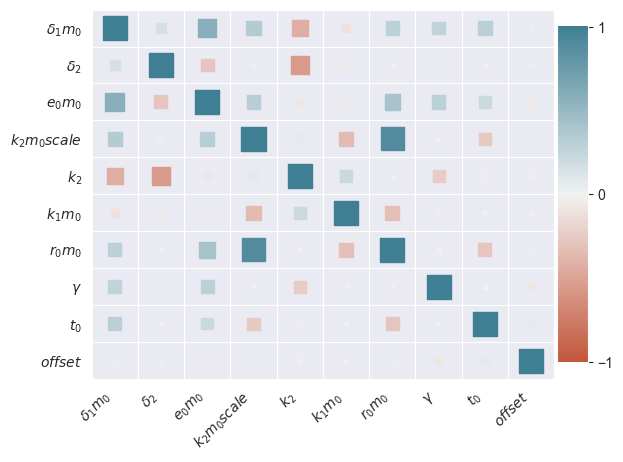

In [44]:
print('Correlation Matrix from Median')
corrplot(corr_df, size_scale=300)

In [45]:
if cov_type == 'cholesky':
    # Find pairs with correlation above the threshold
    threshold = 0
    abs_corr_matrix = corr_df.abs()
    high_corr_pairs = abs_corr_matrix[abs_corr_matrix > threshold].unstack()
    #high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
    high_corr_pairs = high_corr_pairs[high_corr_pairs < 1].sort_values(ascending=False)

    # find indices corresponding to pairs with high correlations
    high_corr_pairs_index = []
    high_corr_pairs_names = []
    for x,y in high_corr_pairs.index:
        name = f'corr_{x}_{y}'
        high_corr_pairs_index += [p_i for p_i, p_name in enumerate(full_param_names) if name == p_name]
        high_corr_pairs_names += [p_name for p_i, p_name in enumerate(full_param_names) if name == p_name]
    print(high_corr_pairs_names, len(high_corr_pairs_index))

# Optimization (Single Experiment)

In [46]:
# create boundaries
lower_bound, upper_bound = create_boundaries_from_prior(
        prior_mean=prior_mean,
        prior_std=prior_std,
        boundary_width_from_prior=2.58,  # 99% of the prior mass is within 2.58 standard deviations
        n_covariates=obj_fun_amortized.n_covariates,
        covariates_bound=(1, 10),
        covariance_format=cov_type
)

# sigma variance is always fixed
index_sigma = [ix for ix, x in enumerate(full_param_names) if 'var-$\\sigma$' == x] + [ix for ix, x in enumerate(full_param_names) if 'var-std_error' == x]
fixed_indices = np.array(index_sigma)  # variance of sigma fixed
fixed_vals = np.array([upper_bound[index_sigma[0]]])

if model_name == 'pharmacokinetic_model':
    # fix mean of random parameters
    eta_fix_idx = [10,11,12,13] # fix eta means to log(1)
    eta_fix_value = [0] * len(eta_fix_idx)
    # fix variance of fixed parameters
    index_thetas = [ix for ix, x in enumerate(full_param_names) if 'theta' in x and 'var' in x]
    theta_var_fix_value = list(upper_bound[index_thetas])
    fixed_indices = np.array(eta_fix_idx + list(fixed_indices) + index_thetas)
    fixed_vals = np.array(eta_fix_value + list(fixed_vals) + theta_var_fix_value)
    # fix sigma like in nonmem
    #index_sigma = [ix for ix, x in enumerate(full_param_names) if '\\sigma$' in x]
    #fixed_indices = np.append(fixed_indices, index_sigma)
    #fixed_vals = np.append(fixed_vals, [0])  # log value of 1
    if cov_type == 'cholesky':
        index_theta_corr = [ix for ix, x in enumerate(full_param_names) if 'theta' in x and 'corr' in x]
        fixed_indices = np.append(fixed_indices, index_theta_corr)
        fixed_vals = np.append(fixed_vals, np.zeros(len(index_theta_corr)))

        # fix eta correlations like in nonmem
        #fix_nonmem = ['corr_$\\eta_0$_$\\eta_2$','corr_$\\eta_0$_$\\eta_3$','corr_$\\eta_1$_$\\eta_3$']
        #index_nonmem = [ix for ix, x in enumerate(full_param_names) if x in fix_nonmem]
        #fixed_indices = np.append(fixed_indices, index_nonmem)
        #fixed_vals = np.append(fixed_vals, [0] * len(index_nonmem))

elif model_name == 'clairon_model':
    index_var_covariates = [ix for ix, x in enumerate(full_param_names) if 'var-c_' in x]
    fixed_indices = np.append(fixed_indices, index_var_covariates)
    fixed_vals = np.append(fixed_vals, upper_bound[index_var_covariates])

only_allow_high_corr = True
if cov_type == 'cholesky':
    if only_allow_high_corr:
        # fix all correlations to 0 but high correlated ones
        index_all_corr = [ix for ix, x in enumerate(full_param_names) if 'corr' in x]
        # remove high_corr_pairs_index from index_all_corr
        index_all_corr = [ix for ix in index_all_corr if ix not in high_corr_pairs_index]
        fixed_indices = np.append(fixed_indices, index_all_corr)
        fixed_vals = np.append(fixed_vals, np.zeros(len(index_all_corr)))


# fix all correlations with sigma to 0
index_sigma_corr = [ix for ix, x in enumerate(full_param_names) if 'sigma' in x and 'corr' in x]
fixed_indices = np.append(fixed_indices, index_sigma_corr)
fixed_vals = np.append(fixed_vals, np.zeros(len(index_sigma_corr)))

In [47]:
#index_offset = [ix for ix, x in enumerate(full_param_names) if '_offset' in x]
#fixed_indices = np.append(fixed_indices, np.array(index_offset))
#fixed_vals = np.append(fixed_vals, np.zeros(len(index_offset)))

In [48]:
#index_offset = [ix for ix, x in enumerate(full_param_names) if 'offset' in x and 'pop' not in x]
#index_scale = [ix for ix, x in enumerate(full_param_names) if 'scale' in x and 'pop' not in x]
#
#fixed_indices = np.append(fixed_indices, index_offset+index_scale)  # fix offset and scale
#fixed_vals = np.append(fixed_vals, upper_bound[index_offset+index_scale])

In [49]:
# make sure that fixed indices are unique
fixed_indices, unique_indices = np.unique(fixed_indices, return_index=True)
fixed_vals = fixed_vals[unique_indices]

In [50]:
if model_name == 'pharmacokinetic_model':
    draw_posterior_samples = lambda data, n_samples: model.draw_posterior_samples(data=data,
                                                                                  n_samples=n_samples)[:, :,
                                                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]]
else:
    draw_posterior_samples = model.draw_posterior_samples

In [51]:
%%time
result_optimization = run_population_optimization(
    bf_amortizer=model.amortizer,
    data=obs_data,
    param_names=full_param_names,
    objective_function=obj_fun_amortized,
    sample_posterior=draw_posterior_samples,
    n_multi_starts=20,
    noise_on_start_param=1,
    n_samples_opt=50,
    lb=lower_bound,
    ub=upper_bound,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_vals,
    file_name='output/real_data/fröhlich_large_diag_new.h5', #f'output/sde-comparison/{model.name}_cells_{n_data}.hd5', #'fröhlich-small-corr-full-50cells-50samples.h5', #'Auto', #f"{model_name}-synthetic.h5",
    verbose=True,
    trace_record=True,
    #pesto_optimizer=optimize.ScipyOptimizer(),
    pesto_multi_processes=10,
    result=None #result_optimization
    )

results = result_optimization.optimize_result.as_dataframe()['x']

Multi-start optimization:   0%|          | 0/2 [00:00<?, ?it/s]

                                    free    lb_full    ub_full
pop-$\delta_1 m_0$                  True  -5.769055   5.769055
pop-$\delta_2$                      True  -6.769055   4.769055
pop-$e_0 m_0$                       True  -3.648671   3.648671
pop-$k_2 m_0 scale$                 True   9.420000  14.580000
pop-$k_2$                           True  -3.648671   3.648671
pop-$k_1 m_0$                       True  -2.648671   4.648671
pop-$r_0 m_0$                       True  -6.648671   0.648671
pop-$\gamma$                        True -11.769055  -0.230945
pop-$t_0$                           True  -3.648671   3.648671
pop-$offset$                        True  -4.319684   8.319684
pop-$\sigma$                        True  -4.648671   2.648671
$\log$ (var-$\delta_1 m_0$)^{-1}    True  -6.573774   4.964336
$\log$ (var-$\delta_2$)^{-1}        True  -6.573774   4.964336
$\log$ (var-$e_0 m_0$)^{-1}         True  -3.995245   3.302097
$\log$ (var-$k_2 m_0 scale$)^{-1}   True  -2.580000   2


Multi-start optimization: 100%|██████████| 2/2 [01:27<00:00, 43.81s/it]

CPU times: user 5.37 s, sys: 3.49 s, total: 8.86 s
Wall time: 1min 27s


In [ ]:
#from pypesto.store import OptimizationResultHDF5Writer
#writer = OptimizationResultHDF5Writer(f'output/{model_name}_real_{n_data}_3.hdf5')
#writer.write(result_optimization)

In [ ]:
#from pypesto.store import OptimizationResultHDF5Reader
#result_optimization2 = OptimizationResultHDF5Reader(f'output/scalability/{model.name}_cells_{n_data}_samples_{50}.hd5').read()
#results = result_optimization.optimize_result.as_dataframe()['x']

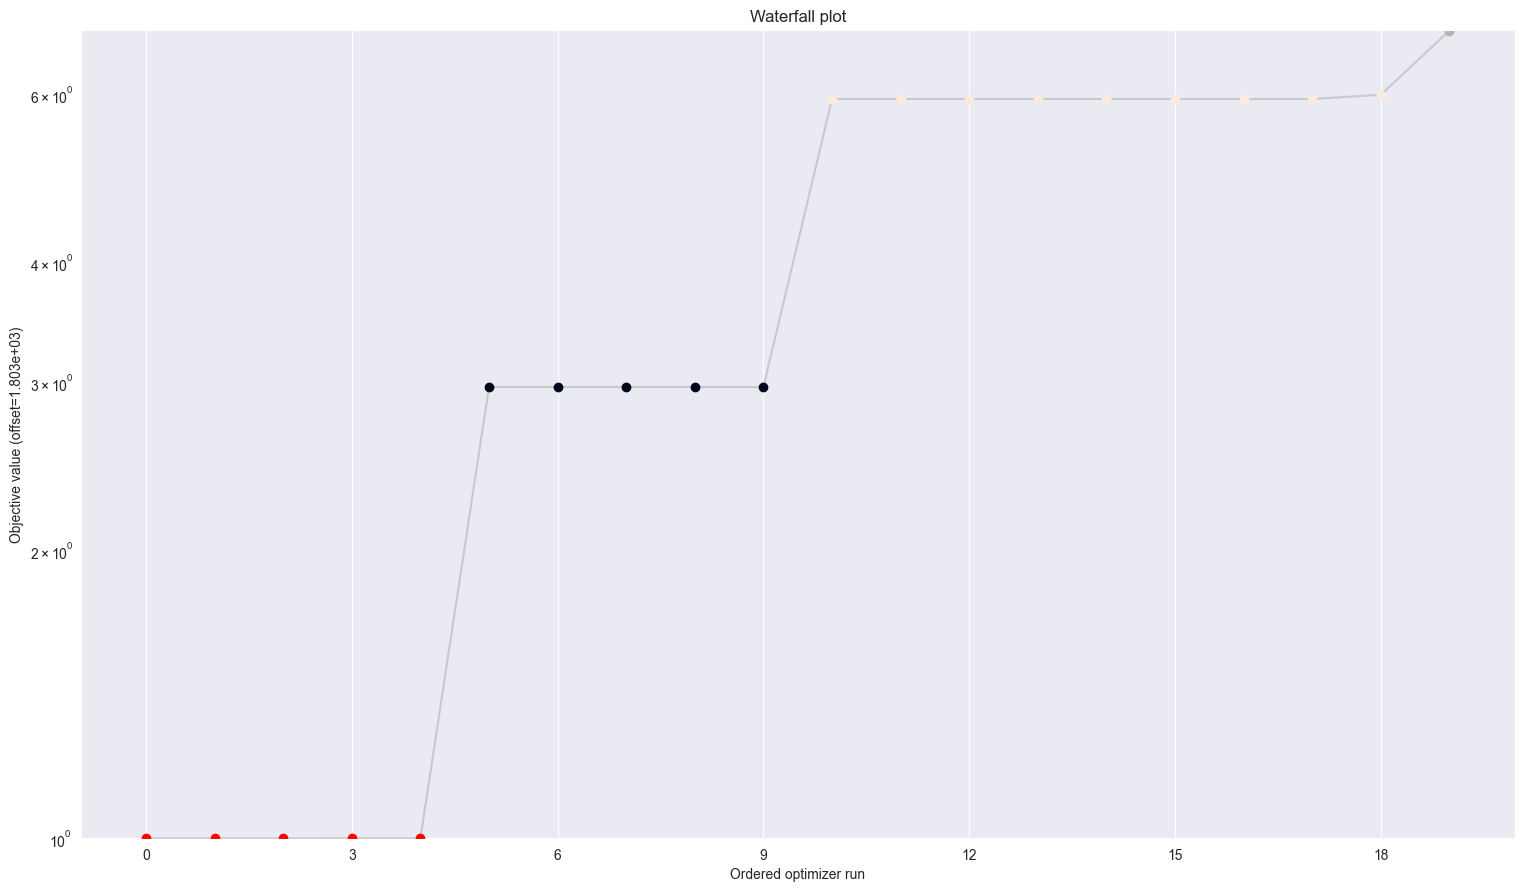

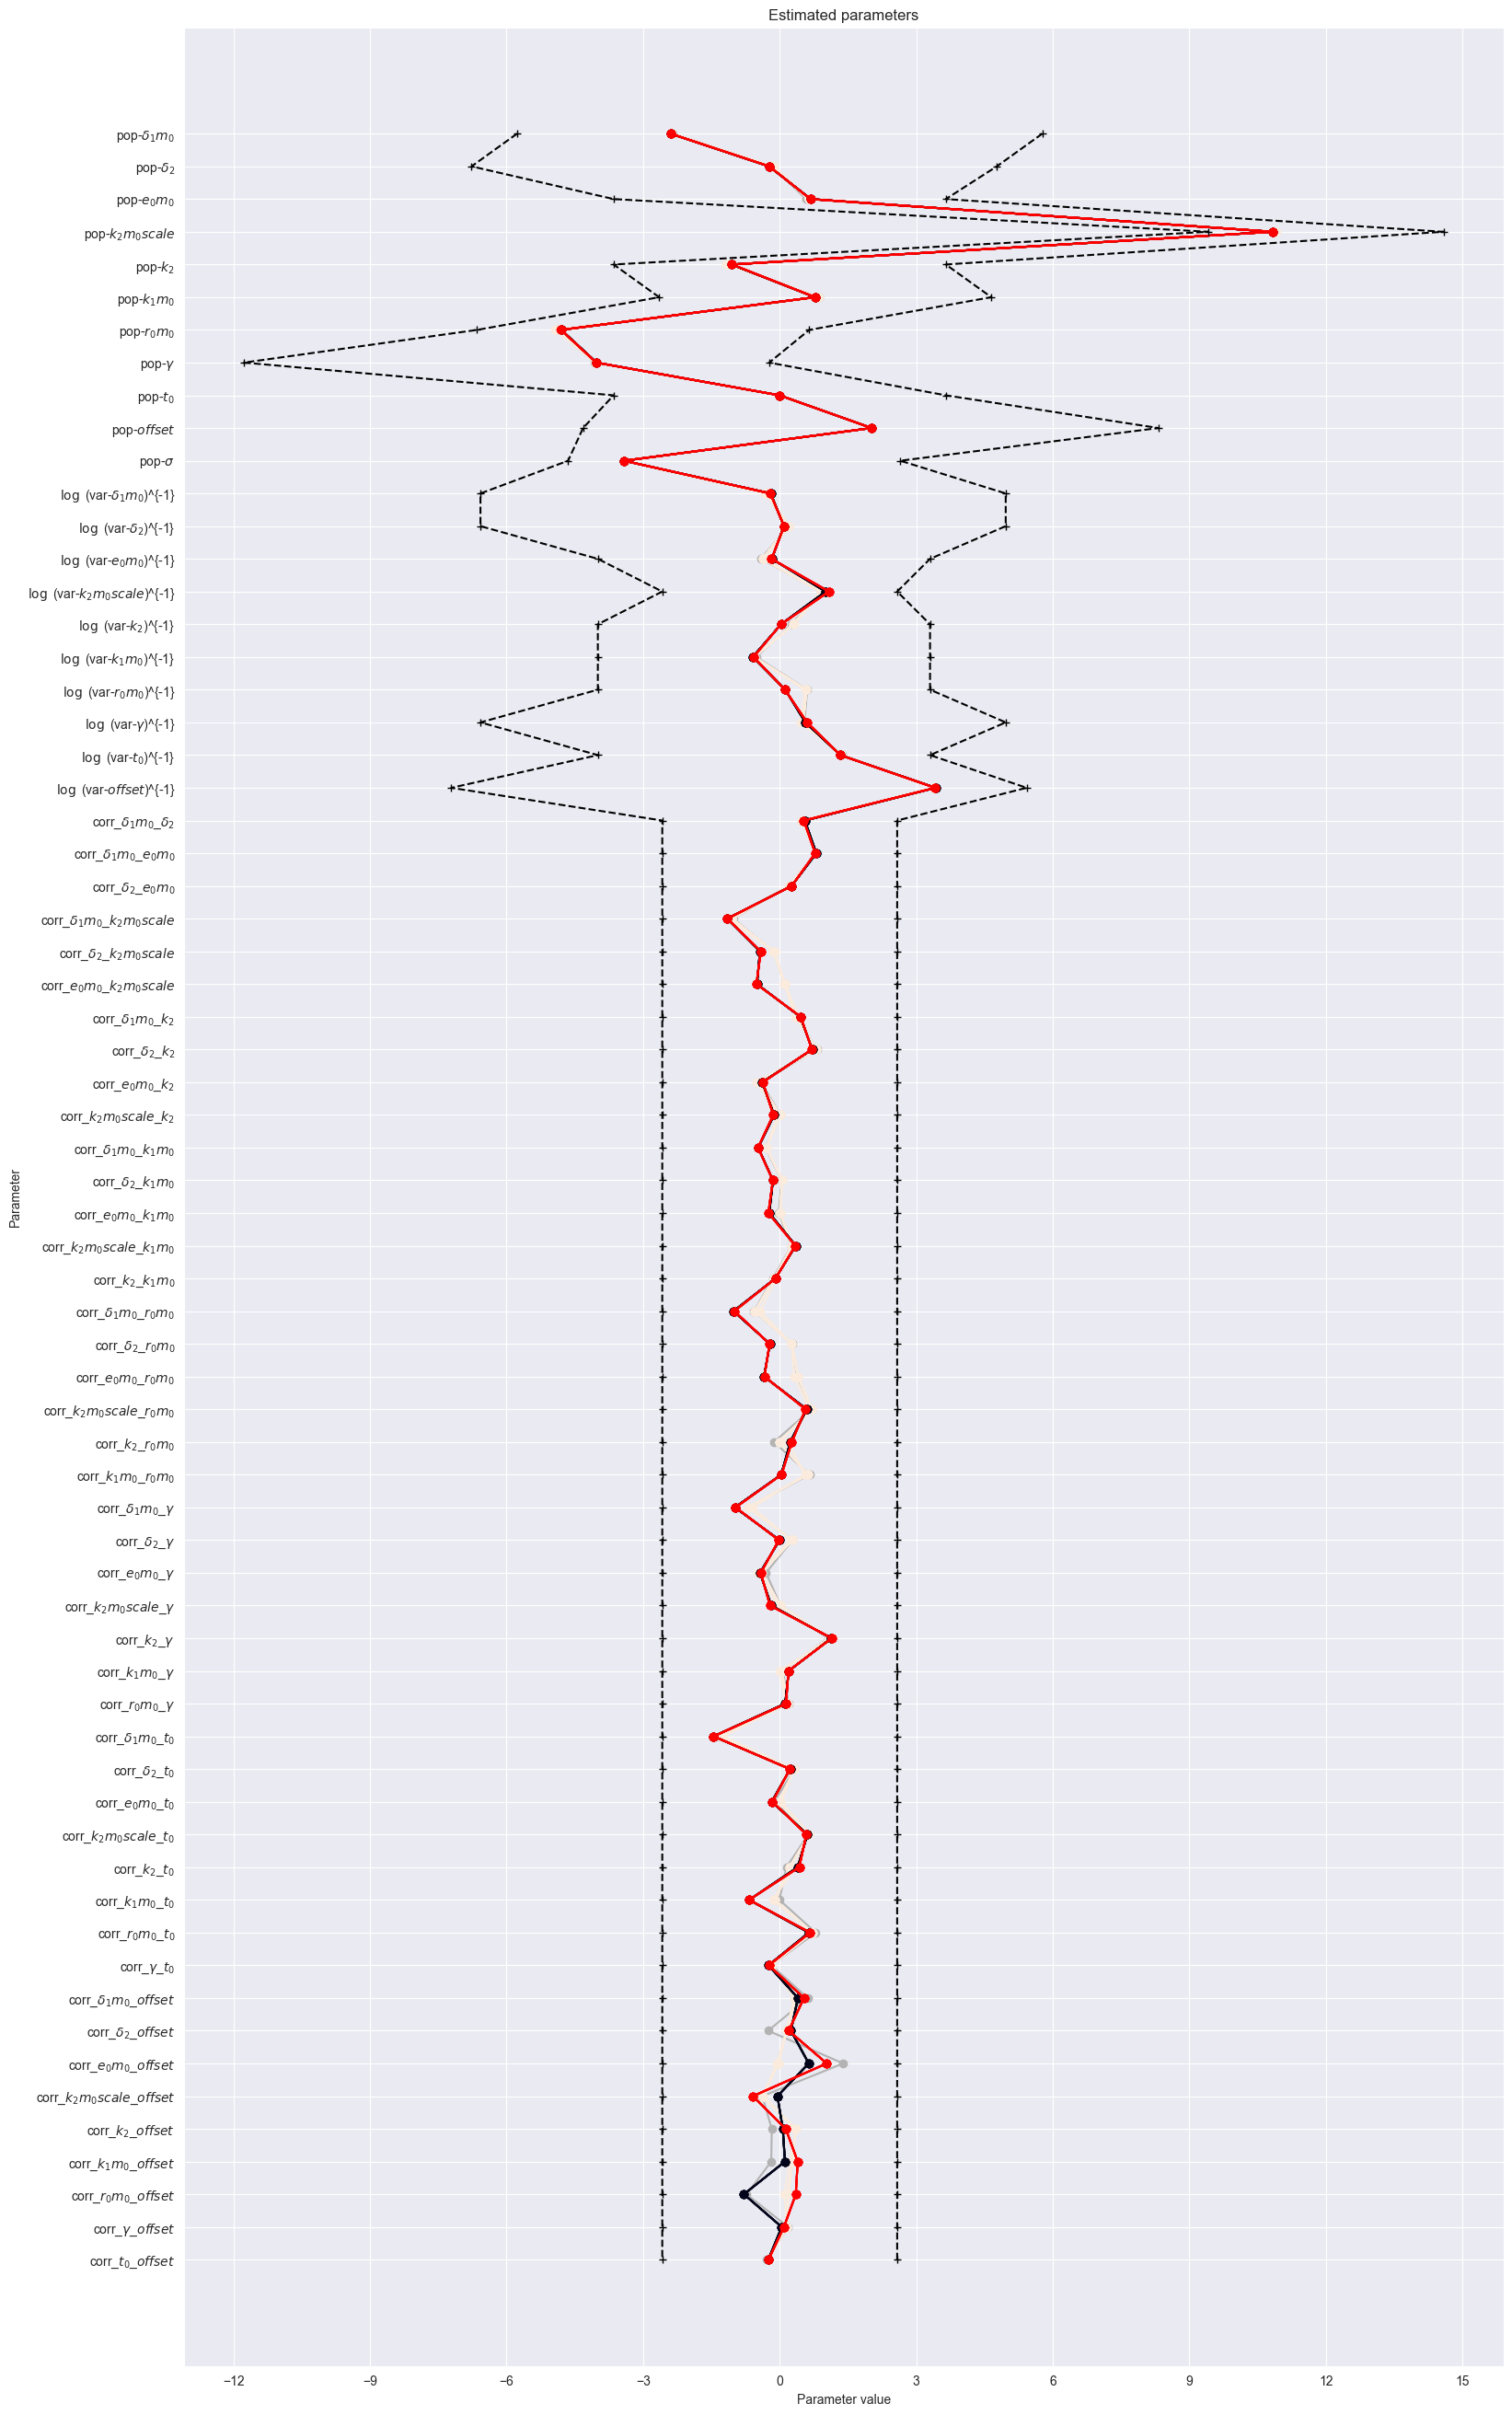

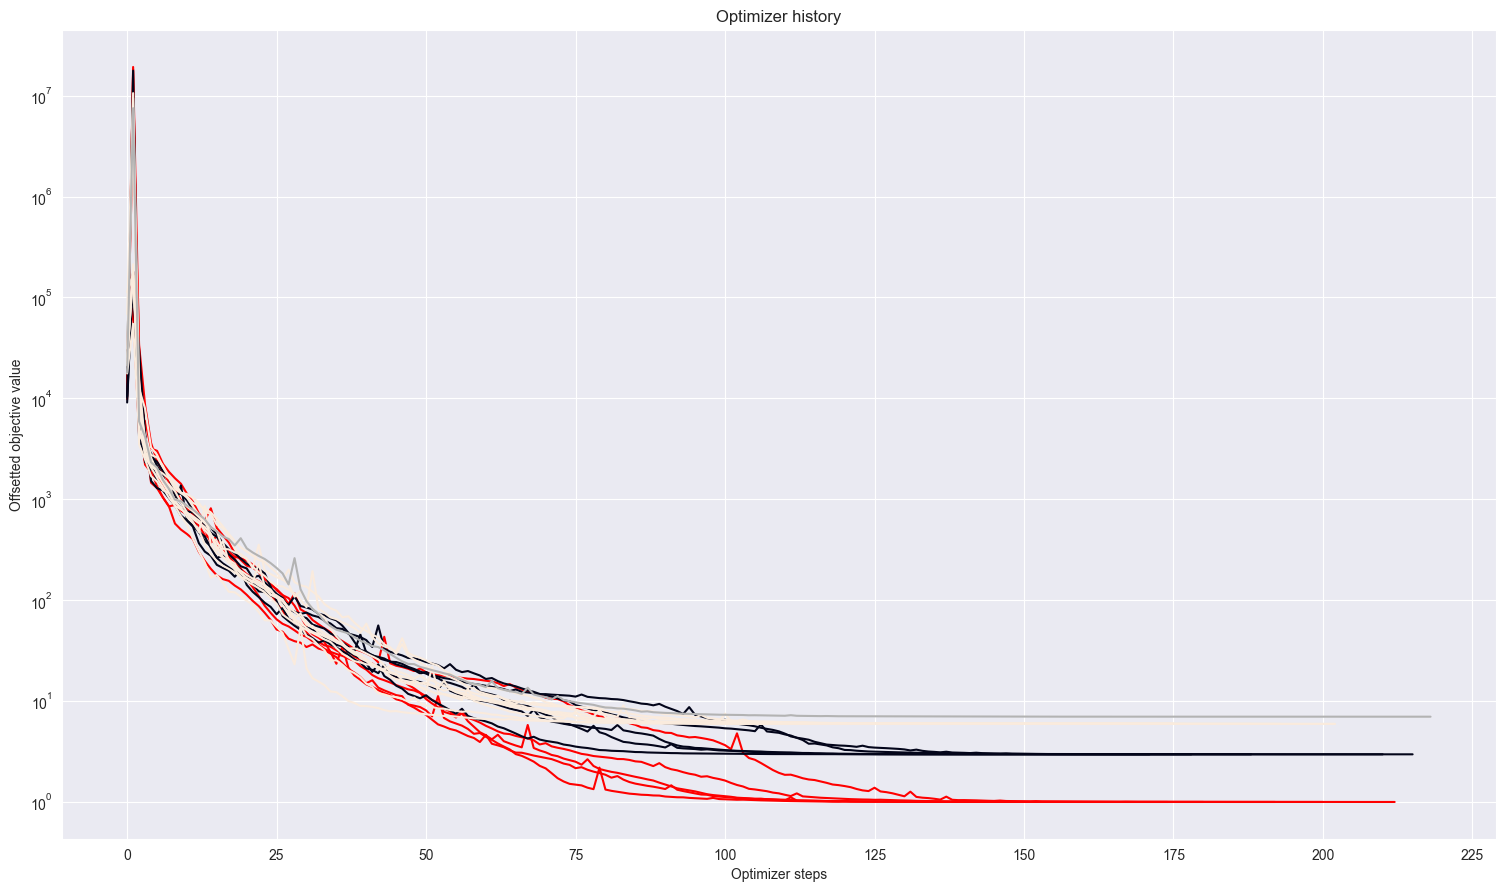

In [32]:
visualize_pesto_result(result_optimization)

In [33]:
if true_pop_parameters is not None:
    print('true values of log-normal distribution')
    df_param_sample = pd.DataFrame(true_pop_parameters[np.newaxis,:].round(4),
                               columns=full_param_names)
    display(df_param_sample)

if results_to_compare is not None:
    print('values of baseline method of log-normal distribution')
    df_param_sample = pd.DataFrame(results_to_compare, columns=full_param_names)
    display(df_param_sample)

print('estimated values of log-normal distribution')
results_transformed = transform_pesto_results(results, len(param_names), cov_type=cov_type)
df_param_sample = pd.DataFrame(results_transformed, columns=full_param_names)
display(df_param_sample)
#df_param_sample.to_csv(f'output/estimated_parameters_{model_name}_{n_data}.csv')

estimated values of log-normal distribution


,pop-$\delta_1 m_0$,pop-$\delta_2$,pop-$e_0 m_0$,pop-$k_2 m_0 scale$,pop-$k_2$,pop-$k_1 m_0$,pop-$r_0 m_0$,pop-$\gamma$,pop-$t_0$,pop-$offset$,...,corr_$\delta_1 m_0$_$\sigma$,corr_$\delta_2$_$\sigma$,corr_$e_0 m_0$_$\sigma$,corr_$k_2 m_0 scale$_$\sigma$,corr_$k_2$_$\sigma$,corr_$k_1 m_0$_$\sigma$,corr_$r_0 m_0$_$\sigma$,corr_$\gamma$_$\sigma$,corr_$t_0$_$\sigma$,corr_$offset$_$\sigma$
0,-2.397079,-0.227298,0.675002,10.835808,-1.048848,0.778818,-4.806618,-4.030655,-0.002737,2.019848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.397077,-0.227228,0.675021,10.835761,-1.048722,0.778817,-4.806580,-4.030721,-0.002733,2.019865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.396675,-0.227097,0.674796,10.835787,-1.048855,0.778724,-4.806541,-4.030621,-0.002685,2.019851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.397191,-0.227233,0.674944,10.835912,-1.048605,0.778924,-4.806875,-4.030815,-0.002684,2.019851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.396965,-0.227231,0.674767,10.835477,-1.048871,0.778841,-4.806445,-4.030669,-0.002742,2.019869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-2.400621,-0.234680,0.682888,10.833966,-1.061571,0.774005,-4.798706,-4.021742,-0.002548,2.019761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-2.400419,-0.234633,0.682543,10.833866,-1.061773,0.774200,-4.798804,-4.021708,-0.002508,2.019761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.400489,-0.234787,0.682692,10.833922,-1.061532,0.774189,-4.798835,-4.021802,-0.002554,2.019765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-2.400487,-0.234781,0.682604,10.834116,-1.061510,0.773983,-4.798857,-4.021787,-0.002574,2.019774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-2.400396,-0.234756,0.682471,10.834120,-1.061512,0.774209,-4.799061,-4.021857,-0.002532,2.019776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
estimated_beta = results[0][:len(param_names)]
estimated_psi = obj_fun_amortized.get_covariance(results[0][len(param_names):])

In [35]:
display(estimated_beta)

array([-2.39707868e+00, -2.27298429e-01,  6.75001812e-01,  1.08358075e+01,
       -1.04884841e+00,  7.78817850e-01, -4.80661772e+00, -4.03065468e+00,
       -2.73705388e-03,  2.01984807e+00, -3.42211187e+00])

In [36]:
display(estimated_psi.diagonal())

array([3.2836442 , 2.01583779, 1.53847294, 0.953435  , 1.79790205,
       1.91485829, 1.03980244, 0.5633588 , 0.26580966, 0.03284342,
       0.03680589])

In [37]:
simulator = model.build_simulator(with_noise=True)

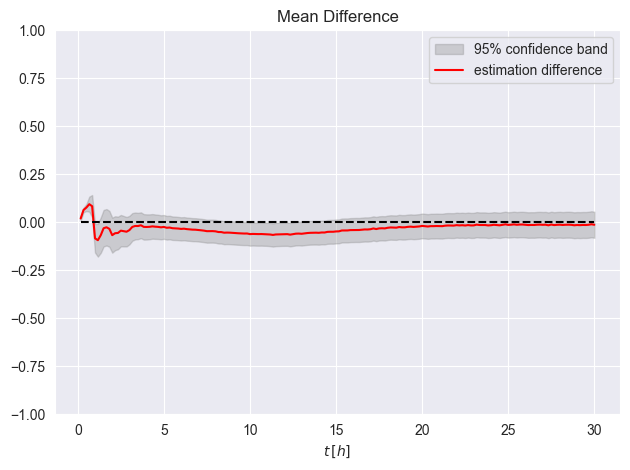

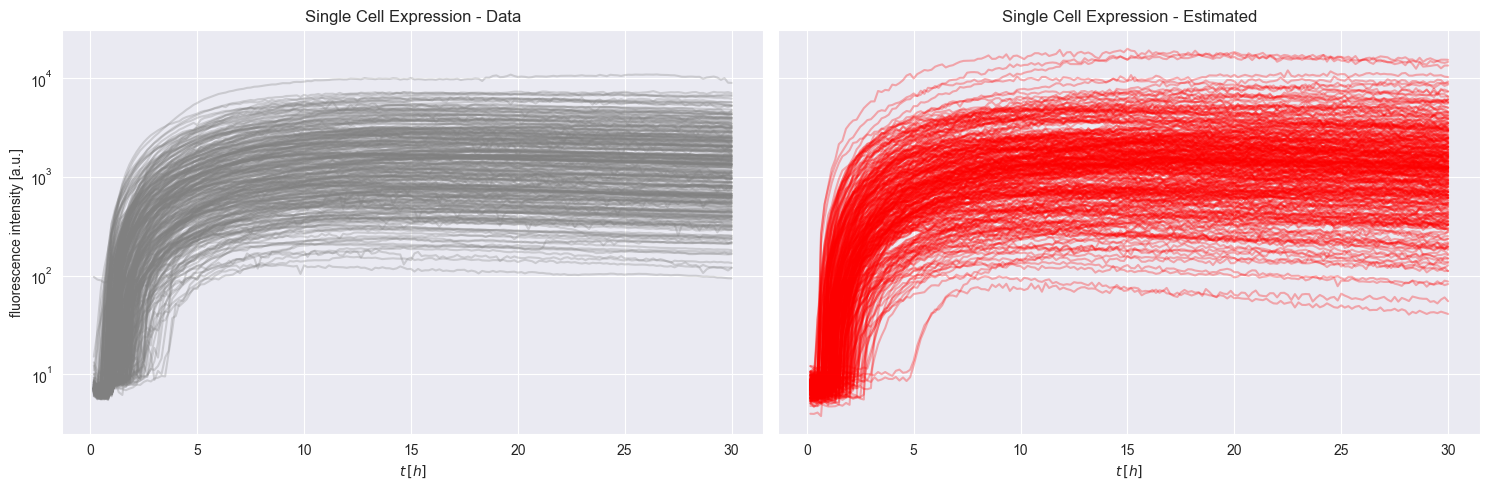

In [38]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data,
                           model_name=model.name,
                           n_trajectories=len(obs_data),
                           simulator=simulator,
                           #save_fig='dif_ode', #model_name+'_eGFP_dif' if load_real_data else model_name+'_synthetic_dif',
                           #estimation_function=np.median,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data,
                           model_name=model.name,
                           n_trajectories=len(obs_data),
                           simulator=simulator,
                           #save_fig=model_name+'_eGFP_estimate' if load_real_data else model_name+'_synthetic_estimate',
                           seed=0)

In [ ]:
plot_parameter_estimates(results_transformed,
                         param_names_plot=full_param_names,
                         prior_mean=prior_mean,
                         prior_std=prior_std,
                         true_parameters=true_pop_parameters,
                         save_fig=False)

In [ ]:
plot_estimated_distributions(results_transformed[0],
                             param_names_plot=param_names,
                             prior_mean=prior_mean,
                             prior_std=prior_std,
                             true_parameters=true_pop_parameters,
                             save_fig=False)

In [ ]:
if results_to_compare is not None:
    compare_list = [results_transformed[0], results_to_compare[0]]
    plot_parameter_estimates(compare_list, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         true_parameters=true_pop_parameters,
                         run_names=['BayesFlow', 'Baseline'],
                         save_fig=False)

    print('Baseline Estimated Parameters')
    plot_parameter_estimates(results_to_compare, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         save_fig=False)

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    min_step_size=0.0005, #0.001
    step_size_factor=1.1, #1.25
    delta_ratio_max=0.05, #0.1
    default_step_size=0.005, #0.01
    ratio_min=0.01, #0.145
)

result_optimization = profile.parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    optimizer=optimize.ScipyOptimizer(),
    engine=engine.MultiProcessEngine(10),
    #profile_index=np.array([0]),
    #result_index=0, # index from which optimization result profiling should be started
    profile_options=profile_options,
    filename=f'output/uncertainty/{model.name}_cells_{n_data}_samples_{50}.hd5',
    #overwrite=True
)

In [ ]:
import matplotlib

matplotlib.rcdefaults()  # for resetting to defaults
plt.rcParams.update({'font.size': 14,
                     #'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'xx-small', # todo: change back to small
                     'ytick.labelsize': 'small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,12)}) #
colors = ['#1f78b4', '#a6cee3', '#b2df8a','#33a02c','#fb9a99']

In [ ]:
ax = visualize.profiles(result_optimization, size=(16,12))
#plt.savefig('plots/synthetic_profiles_small_stochastic_data.pdf', bbox_inches='tight', dpi=600, format='pdf')
plt.show()

In [ ]:
ax = visualize.profile_cis(result_optimization) #,
                                  #profile_indices=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
#plt.savefig('plots/synthetic_FIM_profiles_cis.png')
plt.show()

In [ ]:
def plot_intervals(median, cis,
                   ax=None, alpha=0.3,
                   par_names: list = None,
                   levels: list = [0.05, 0.95],
                   offset: float = 0,
                   color: str = None):
    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par + offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=8 / len(levels) * (len(levels) - i_c),
                      alpha=1 / len(levels) * (len(levels) - i_c),
                      color=color)
            ax.vlines(median[i_par], offset + i_par - 0.15, offset + i_par + 0.15, color="black", alpha=alpha)
    xmin, xmax = ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par + 0.5, xmin, xmax, color="black", linewidth=1, linestyle="dashed", alpha=0.1)

In [ ]:
if model_name == 'pharmacokinetic_model':
    plt.scatter(np.arange(1, len(raw_data['ofv'])+1-15), -raw_data['ofv'][:-15])
    plt.yscale('log')
    plt.show()

In [ ]:
if model_name == 'pharmacokinetic_model':
    x_names = [result_optimization.problem.x_names[ix] for ix in profile_indices]
    x_names[11] = 'var $\\eta_0$'
    x_names[12] = 'var $\\eta_1$'
    x_names[13] = 'var $\\eta_2$'
    x_names[14] = 'var $\\eta_3$'

    n_results_compare = 100
    results_compare_min = np.min(results_to_compare[:n_results_compare], axis=0)
    results_compare_max = np.max(results_to_compare[:n_results_compare], axis=0)
    intervals_compare = np.array([results_compare_min, results_compare_max]).T

    baseline_params = [results_to_compare[0][ix] for ix in profile_indices]
    intervals_compare_non_fixed = [intervals_compare[ix] for ix in profile_indices]

    # wt and DOS are not removed from the prior
    prior_mean_non_fixed = [model.prior_mean[ix] for ix in profile_indices if ix <= model.n_params]
    prior_mean_non_fixed[-1] = model.prior_mean[14+2]
    prior_std_non_fixed = np.array([model.prior_std[ix] for ix in profile_indices if ix <= model.n_params])
    prior_std_non_fixed[-1] = model.prior_std[14+2]
    prior_intervals = np.array([prior_mean_non_fixed - 1.96*prior_std_non_fixed,
                                prior_mean_non_fixed + 1.96*prior_std_non_fixed]).T

    plt.figure(figsize=(8,6))
    plt.title('\\bf{C}', loc='left')
    for y, (ci_l, ci_u) in enumerate(prior_intervals):
        plt.plot([ci_l, ci_u], [y, y], linestyle='--', color='g', label='95\% Prior-Region' if y == 0 else None)

    for y, (l, u) in enumerate(intervals_compare_non_fixed):
        if y < 11:
            plt.plot([l, u], [y, y], marker='|', color='b', label=f'Range of Best Fits Baseline' if y == 0 else None)
            plt.plot(baseline_params[y], y, marker='x', color='y', label='Optimal Fit Baseline' if y == 0 else None)
        else:
            # convert variance params
            plt.plot([np.exp(-u), np.exp(-l)], [y, y], marker='|', color='b')
            plt.plot(np.exp(-baseline_params[y]), y, marker='x', color='y')

    for y, (ci_l, ci_u) in enumerate(intervals):
        if y < 11:
            plt.plot([ci_l, ci_u], [y, y], marker='|', color='r', label='CI Amortized NLME' if y == 0 else None)
        else:
            # convert variance params
            plt.plot([np.exp(-ci_u), np.exp(-ci_l)], [y, y], marker='|', color='r')

    #plt.xscale('symlog')
    plt.yticks(ticks=np.arange(len(x_names)), labels=x_names)
    plt.xlabel('Parameter Value')
    plt.legend()
    plt.show()

Uncertainty based on FIM

In [ ]:
result_optimization = profile.approximate_parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    #profile_index=np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #result_index=0, # index from which optimization result profiling should be started
)

In [ ]:
visualize.profiles(result_optimization)
#plt.savefig('plots/synthetic_FIM_profiles.png')
plt.show()

In [ ]:
n_indv = obs_data.shape[0]
confidence_ratio = profile.chi2_quantile_to_ratio(alpha=0.95, df=n_indv-(model.n_params*2))

confidence_intervals = np.zeros((model.n_params*2, 2))

for param_idx in range(model.n_params*2):
    try:
        xs = result_optimization.profile_result.list[0][param_idx]['x_path'][param_idx]
        ratios = result_optimization.profile_result.list[0][0]['ratio_path']
        confidence_intervals[param_idx] = profile.calculate_approximate_ci(xs, ratios,
                                                                            confidence_ratio=confidence_ratio)
    except TypeError:
        print(f'for {full_param_names[param_idx]} confidence interval could not be estimated')

confidence_intervals